---
# **Model Giving good Stats - Use this one for the project**
Add comments and explanation texts, clean the code, perharps use another notebook for the end result model
---


In [1]:
pip install --upgrade pandas pip install --upgrade pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime

In [4]:
import pandas as pd

In [5]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

In [6]:
#df = pd.read_csv("BTC-USD.csv")
#df.head()

# Data2 Getting Yahoo Finance from pdr = data from 2020 afterwards
df = pdr.get_data_yahoo('BTC-USD')

In [7]:
df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis=1, inplace=True)

In [8]:
# For Data2 - Transforming the index in a Date columns
df=df.reset_index()

In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df.tail()

,Date,Close
1821,2022-04-27,39241.121094
1822,2022-04-28,39773.828125
1823,2022-04-29,38609.824219
1824,2022-04-30,37714.875000
1825,2022-05-01,38460.105469


In [10]:
HORIZON = 10

model = ExponentialSmoothing(endog = df['Close'])
results = model.fit()

preds = results.get_forecast(steps=HORIZON)

preds.summary_frame(alpha=0.2).head()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
1826,38441.439461,979.342097,37186.362063,39696.516859
1827,38441.439461,1367.195654,36689.307730,40193.571192
1828,38441.439461,1667.134359,36304.920813,40577.958108
1829,38441.439461,1920.794103,35979.842772,40903.036150
1830,38441.439461,2144.659180,35692.948131,41189.930790


In [11]:
print(results.forecast(steps=1))

1826    38441.439461
dtype: float64


In [12]:
x = results.forecast(steps=1)
print(x)
if x.item() > 36996.509921:
    print('yes')
else:
    print('No')

1826    38441.439461
dtype: float64
yes


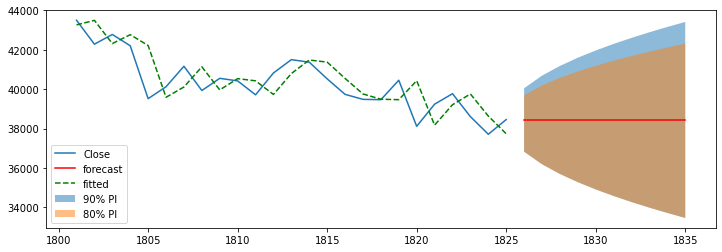

In [13]:
ax = df['Close'].iloc[-25:].plot(figsize=(12,4))
forecast_80 = preds.summary_frame(alpha=0.2)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
forecast_90 = preds.summary_frame(alpha=0.1)[['mean', 'mean_ci_lower', 'mean_ci_upper']]

ax.fill_between(forecast_90.index, forecast_90['mean_ci_lower'], forecast_90['mean_ci_upper'], alpha=0.5, label='90% PI')
ax.fill_between(forecast_80.index, forecast_90['mean_ci_lower'], forecast_80['mean_ci_upper'], alpha=0.5, label='80% PI')

forecast_80['mean'].iloc[-25:].plot(ax=ax, label='forecast', color='red')

results.fittedvalues.iloc[-25:].plot(ax=ax, label='fitted', color='green', linestyle='--')

ax.legend(loc=3)

Statistical model

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1826
Model:                   ETS(A, N, N)   Log Likelihood              -15166.426
Date:                Sun, 01 May 2022   AIC                          30338.853
Time:                        18:47:54   BIC                          30355.383
Sample:                             0   HQIC                         30344.950
                               - 1826   Scale                       959110.943
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9741      0.015     66.458      0.000       0.945       1.003
initial_level    1452.8199   4.96e-13   2.93e+15      0.000    1452.820    1452.820
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8890.60
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.84   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

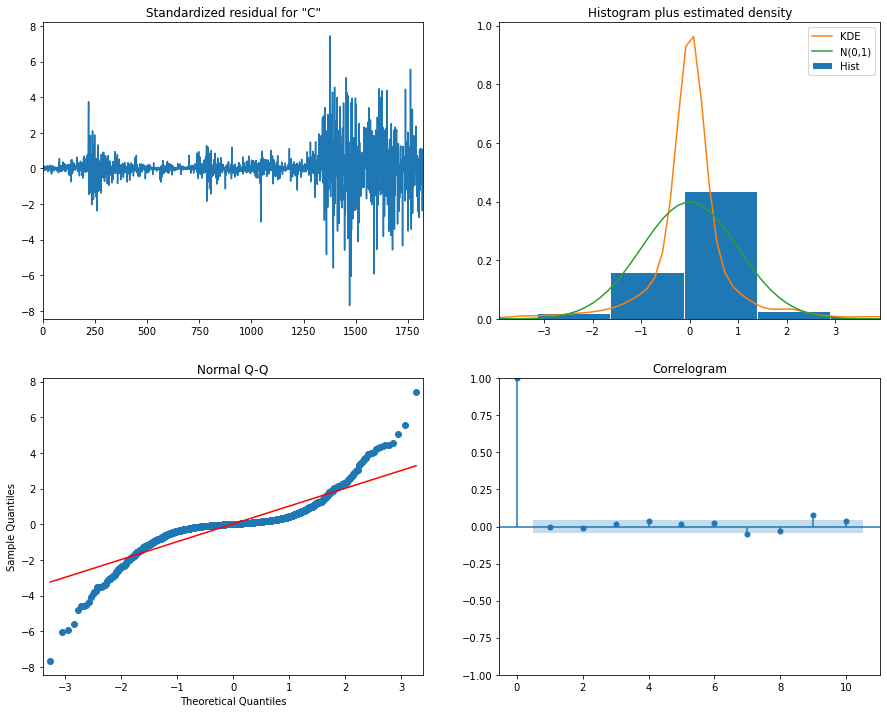

In [16]:
# Diagnosing the model residuals
results.plot_diagnostics(figsize = (15, 12))
plt.show()

In [17]:
# Divide into train and validation set to calculate R-squared score
train = df[:int(0.85 * (len(df)))]
test  = df[int(0.85 * (len(df))):]

train.shape, test.shape

((1552, 2), (274, 2))

In [18]:
start = len(train)
end   = len(train) + len(test) - 1
predictions = results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('Simple Exponential Smoothing Predictions')
print(predictions)

1552    41640.472291
1553    40017.996773
1554    39223.063298
1555    38180.672343
1556    39706.957043
            ...     
1821    38177.376082
1822    39213.593232
1823    39759.330225
1824    38639.571426
1825    37738.804528
Name: Simple Exponential Smoothing Predictions, Length: 274, dtype: float64


In [19]:
# Create a dataframe to store r2 score
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Close'], predictions)}, index = [0])

# Display the results
evaluation_results

,r2_score
0,0.957968


# Function to train the model, request external API and come up with an "advice"

The function below will perform the following tasks:
*  Train the model once a day
*  Define the absolute median of the trained data
*  HTTP request to find the real time of the crypto
*  According to the position of real-time value in comparison with the median, return an statistical advice



In [20]:
import requests

In [21]:
from threading import Timer

In [22]:
def find_real_time_value():
    real_time_price = requests.get('https://bitpay.com/api/rates/USD')
    x = real_time_price.json()
    return x['rate']

#find_real_time_value()

In [23]:
def get_middle_value(data):
    high = 0
    low = 0
    middle_value = 0
    
    # Finding higher and lowest values in order to get a middle value
    for x in data:
        if high > x:
            high = high
        else:
            high = x
        
        if low < x:
            low = low
        else:
            low = x
        
        middle_value = (high - low)/2 
            
    return middle_value
    #return data.median()

test = get_middle_value(df['Close'])
print(test)

33783.4140625


In [24]:
def get_highest(data):
    highest = 0
    for x in data:
        if highest > x:
            highest = highest
        else:
            highest = x
            
    return highest

In [25]:
def get_lowest(data):
    lowest = 0
    for x in data:
        if lowest < x:
            lowest = lowest
        else:
            lowest = x
            
    return lowest

In [57]:
def statistical_decision(model, data):
    # Defining boundaries
    high = get_highest(data)
    low = get_lowest(data)
    
    top_bounder = 0
    botton_bounder = 0
    
    run = True
    
    # to be returned
    buy = 'Buy'
    sell = 'Sell'
    
    # Checking real time of the bitcoin in USD
    x = find_real_time_value()
    
    # Get median
    # Check this maths part
    m = get_middle_value(data)
    top_bounder = (m + high)/3
    bottom_bounder = (m + low)/3
    
    # Train the Model
    # Make a function for it in the beginning of this notebook and call here again in a certain time interval
    # Scheduled to be done on Monday 02nd May 2022
    
    
    # Decision logic
    v = model.forecast(steps=1)
    #print(v)
    
    if v.item() > top_bounder * 2:
        print('Sell')
        #return sell
    
    elif v.item() < bottom_bounder * 2:
        print('Sell')
        #return sell
    
    elif v.item() > bottom_bounder:
        print('Buy')
        #return buy
    
    elif v.item() < top_bounder:
        print('Buy')
        #return buy
    def call():
        statistical_decision(results, df['Close'])
        
    if run:
        Timer(60, call).start()
        
#statistical_decision(results, df['Close'])
    

In [58]:
statistical_decision(results, df['Close'])

Buy
Buy
Buy
Buy
Buy
Buy
Buy


# Dashboard

In [ ]:
pip install explainerdashboard

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
array = df.values
X = array[:100]
y = array[-100:]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)